# Clustering using Zillow Data

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np

# explore/ stat
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# default pandas decimal display formatting
pd.options.display.float_format='{:20,.2f}'.format

# support modules
from env import host, user, password
import acquire
import summarize
import prepare
import explore


### Acquire 
**Summarize the data to get an idea of how to best prepare for exploration.**

In [2]:
# acquire data, only retreive 261 > single residential family
df = acquire.get_zillow_data().set_index("parcelid")

In [3]:
# remove unit counts of two and three
df = df [(df.unitcnt != 2) | (df.unitcnt != 3)]

In [4]:
df.head()

,county,tax_rate,id,airconditioningtypeid,airconditioningdesc,architecturalstyletypeid,architecturalstyledesc,basementsqft,bathroomcnt,bedroomcnt,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,typeconstructiontypeid,typeconstructiondesc,censustractandblock,transactiondate,logerror,transactions
parcelid,,,,,,,,,,,,,,,,,,,,,
17052889,Ventura,0.01,1387261,nan,None,nan,None,nan,1.00,2.00,...,"376,000.00","5,672.48",None,nan,nan,None,"61,110,010,023,006.00",2017-01-01,0.06,1
17110996,Ventura,0.01,43675,nan,None,nan,None,nan,2.50,3.00,...,"99,028.00","2,204.84",None,nan,nan,None,"61,110,050,041,163.00",2017-01-02,0.01,1
17134185,Ventura,0.01,2490820,nan,None,nan,None,nan,2.00,4.00,...,"273,509.00","4,557.52",None,nan,nan,None,"61,110,055,042,000.00",2017-01-03,0.06,1
17292247,Ventura,0.02,269618,nan,None,nan,None,nan,2.00,3.00,...,"24,808.00","1,450.06",None,nan,nan,None,"61,110,059,063,018.00",2017-01-03,-0.42,1
17141654,Ventura,0.01,74982,nan,None,nan,None,nan,3.00,4.00,...,"126,138.00","4,139.18",None,nan,nan,None,"61,110,053,061,004.00",2017-01-03,-0.02,1


In [5]:
df.shape

(52169, 71)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tax_rate,"52,164.00",0.01,0.01,0.00,0.01,0.01,0.01,0.82
id,"52,169.00","1,496,932.46","859,434.15",349.00,"757,739.00","1,500,051.00","2,241,574.00","2,982,270.00"
airconditioningtypeid,"13,605.00",2.44,3.85,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"52,169.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,169.00",3.31,0.93,1.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,628.00",6.27,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,153.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
calculatedfinishedsquarefeet,"52,161.00","1,923.74","1,003.72",152.00,"1,268.00","1,660.00","2,306.00","21,929.00"


In [7]:
# Use summarize.py to display all summaries for all features and get a full picture of the data.
summarize.df_summary(df)

--- Shape: (52169, 71)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52169 entries, 17052889 to 14447871
Data columns (total 71 columns):
county                          52169 non-null object
tax_rate                        52164 non-null float64
id                              52169 non-null int64
airconditioningtypeid           13605 non-null float64
airconditioningdesc             13605 non-null object
architecturalstyletypeid        70 non-null float64
architecturalstyledesc          70 non-null object
basementsqft                    47 non-null float64
bathroomcnt                     52169 non-null float64
bedroomcnt                      52169 non-null float64
buildingclasstypeid             0 non-null object
buildingclassdesc               0 non-null object
buildingqualitytypeid           33628 non-null float64
calculatedbathnbr               52153 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
decktypeid                      387 non-null flo

Los Angeles                         33752
Orange                              14061
Ventura                              4356
(-0.0017230000000000001, 0.0817]    52125
(0.0817, 0.163]                        30
(0.163, 0.245]                          3
(0.245, 0.327]                          2
(0.327, 0.408]                          1
(0.408, 0.49]                           1
(0.49, 0.572]                           1
(0.572, 0.653]                          0
(0.653, 0.735]                          0
(0.735, 0.816]                          1
(-2632.922, 298541.1]                5152
(298541.1, 596733.2]                 5120
(596733.2, 894925.3]                 5123
(894925.3, 1193117.4]                5235
(1193117.4, 1491309.5]               5306
(1491309.5, 1789501.6]               5329
(1789501.6, 2087693.7]               5226
(2087693.7, 2385885.8]               5167
(2385885.8, 2684077.9]               5223
(2684077.9, 2982270.0]               5288
(0.987, 2.2]                      

##### From this summary, we are able to see that we have a lot of missing values and data types that aren't what we would want them to be.

**Task 1:** Summarize the null values and decide how to handle them, either remove or impute.

**Task 2:** Decide on appropiate data type for each column and make changes as neccesary.

In [8]:
# This dataframe shows the number of missing rows and the percentage rows missing from each column.
summarize.nulls_by_col(df)

,num_rows_missing,pct_rows_missing
county,0,0.00
tax_rate,5,0.00
id,0,0.00
airconditioningtypeid,38564,0.74
airconditioningdesc,38564,0.74
architecturalstyletypeid,52099,1.00
architecturalstyledesc,52099,1.00
basementsqft,52122,1.00
bathroomcnt,0,0.00
bedroomcnt,0,0.00


In [9]:
# This dataframe shows  the number of missing columns, percentage of missing columns, and the ID of the column.
summarize.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,parcelid
0,23,32.3943661971831,2
1,24,33.80281690140845,12
2,25,35.2112676056338,11
3,26,36.61971830985916,30
4,27,38.028169014084504,177
5,28,39.436619718309856,389
6,29,40.845070422535215,2527
7,30,42.25352112676056,2194
8,31,43.66197183098591,5986
9,32,45.07042253521127,8880


##### Now we will use a function to deal with missing values in the columns and the rows. If a row has more than 50% nulls, they will be removed. If a columns has more than 75% nulls, they will be removed.

In [10]:
df = prepare.handle_missing_values(df, prop_required_column = .5, prop_required_row = .75)

After using this function, we didn't lose any rows, but we lost a lot of columns.

In [11]:
df.shape

(52168, 37)

In [12]:
# summarize.report_remain_nulls_by_col(df, num_rows_of_interest) to show the remaining missing rows and the percentage. From this, we will decide if we want to drop or impute.
summarize.report_remain_nulls_by_col(df, 200)

,num_rows_missing,pct_rows_missing
buildingqualitytypeid,18540,0.36
heatingorsystemtypeid,18344,0.35
heatingorsystemdesc,18344,0.35
lotsizesquarefeet,354,0.01
propertyzoningdesc,18478,0.35
regionidcity,1028,0.02
unitcnt,18450,0.35


In [13]:
# 1st feature construction
# Adjust the 'yearbuilt' column to work with 'age'. This will make it easier to to work with.
df['age'] = 2017 - df.yearbuilt

In [14]:
# These are the columns we will drop either because we do not need them or they are duplicates.
df = df.drop(columns = ['yearbuilt','propertylandusedesc','propertylandusetypeid','fullbathcnt','state','calculatedbathnbr','id','finishedsquarefeet12', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'heatingorsystemdesc', 'propertyzoningdesc', 'propertyzoningdesc', 'unitcnt'])

In [15]:
df.shape

(52168, 25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1608c780>,
      dtype=object)

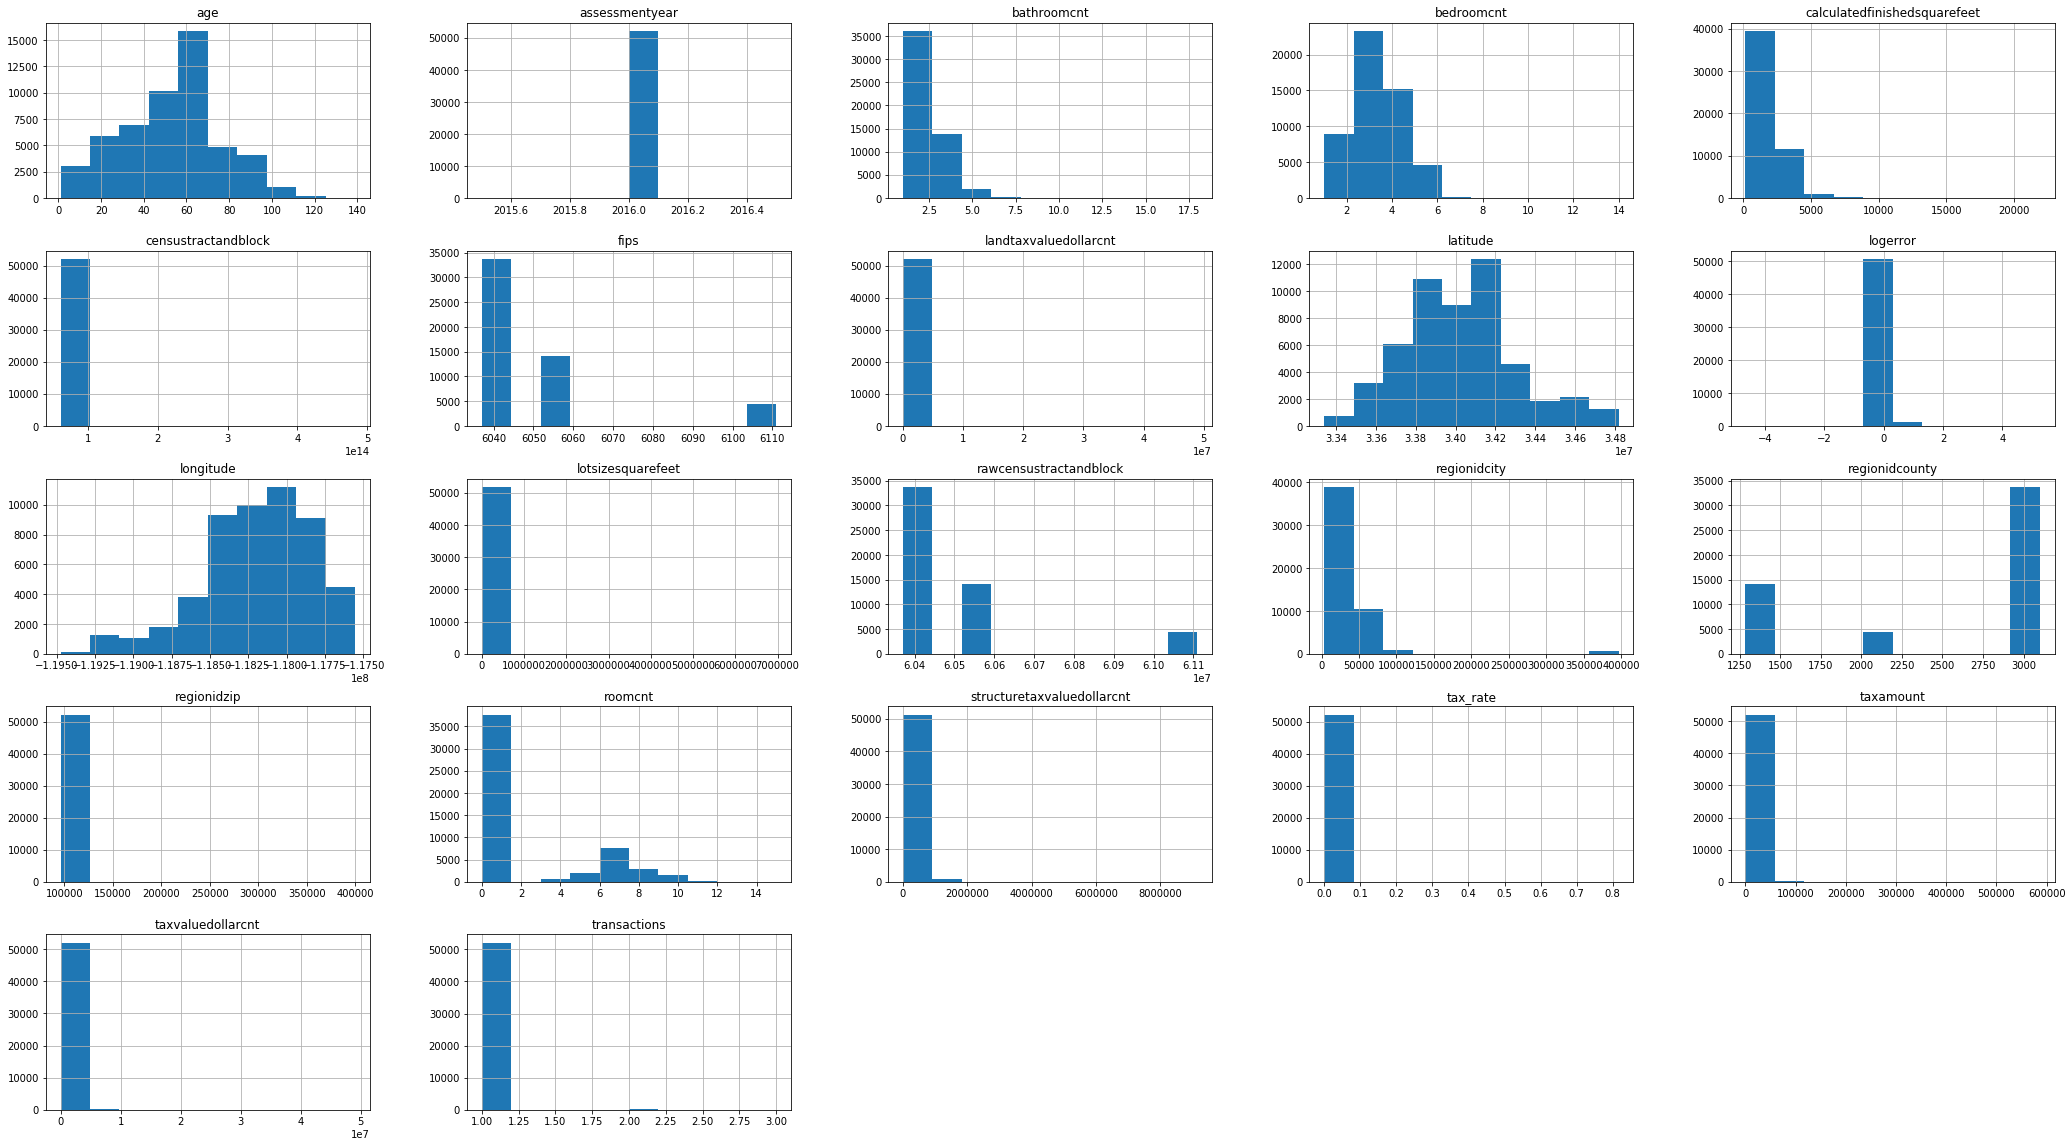

In [16]:
# Look at the distribution of the remaining features to see if there are any outliers.
# Identify outliers visually
df.hist(figsize=(36,20))

In [17]:
col_out = ["tax_rate", "bathroomcnt", "bedroomcnt","calculatedfinishedsquarefeet", "lotsizesquarefeet", "roomcnt", "taxamount"]

In [18]:
def remove_outliers_iqr(df, col):
    #for col in columns:
        #q75, q25 = np.percentile(df[col], [75,25])

    q1, q3 = df[col].quantile([.25, .75])
    iqr = q3 - q1
    ub = q3 + 3 * iqr
    lb = q1 - 3 * iqr

    df = df[df[col] <= ub]
    df = df[df[col] >= lb]
    return df

In [19]:
# Remove outliers in each of the following columns.
df = remove_outliers_iqr(df, "tax_rate")
df = remove_outliers_iqr(df, "bathroomcnt")
df = remove_outliers_iqr(df, "bedroomcnt")
df = remove_outliers_iqr(df, "calculatedfinishedsquarefeet")
df = remove_outliers_iqr(df, "lotsizesquarefeet")
df = remove_outliers_iqr(df, "roomcnt")
df = remove_outliers_iqr(df, "taxamount")

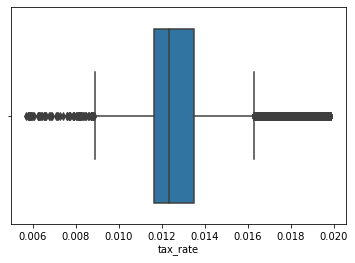

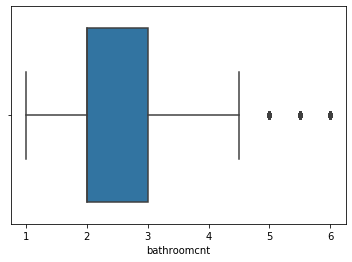

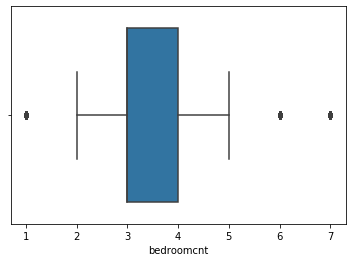

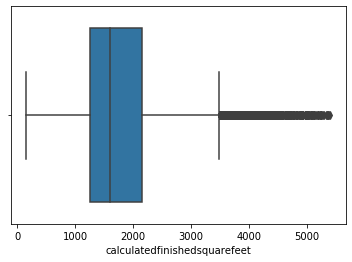

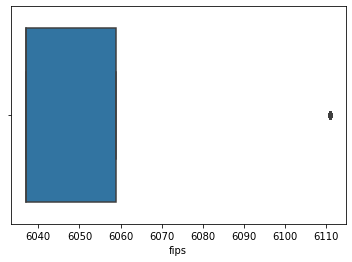

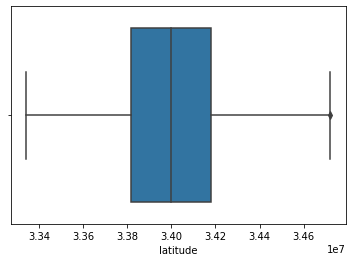

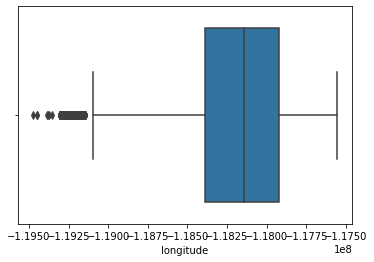

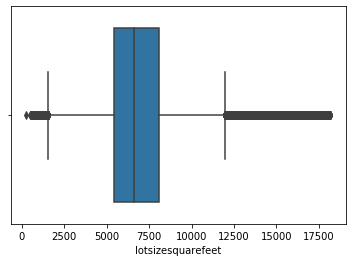

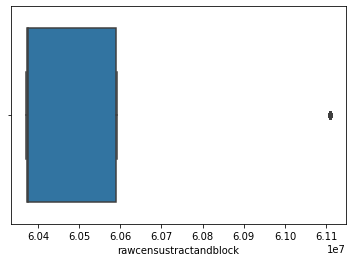

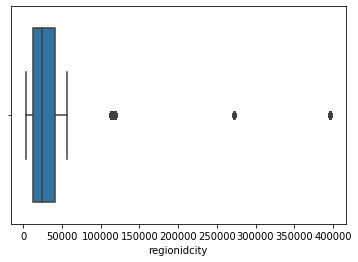

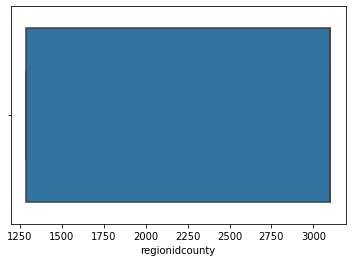

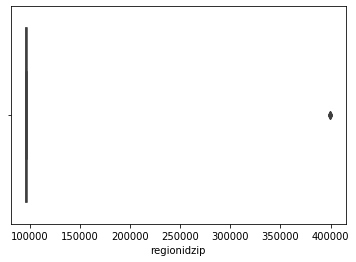

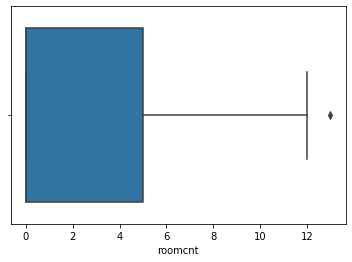

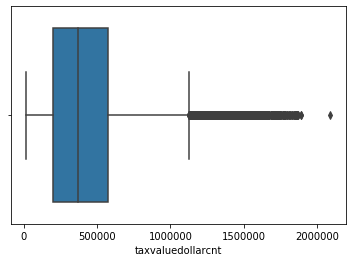

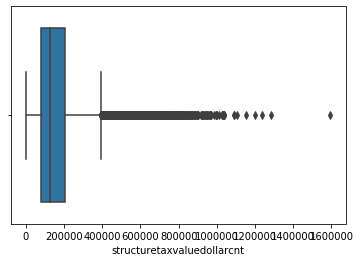

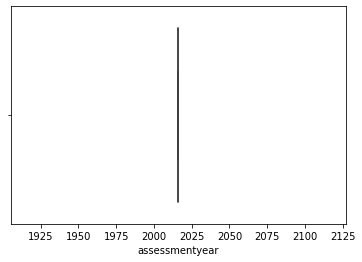

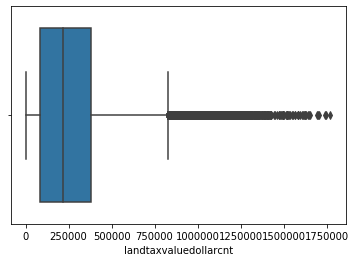

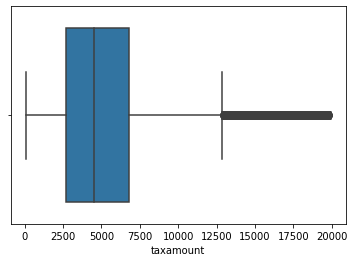

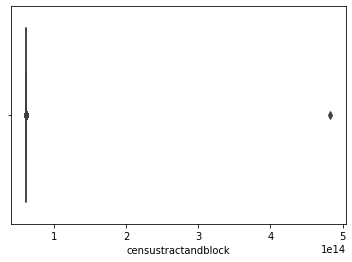

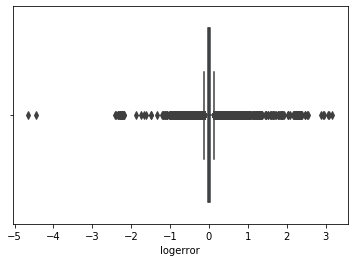

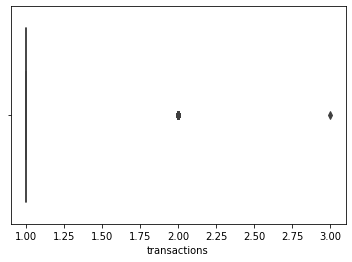

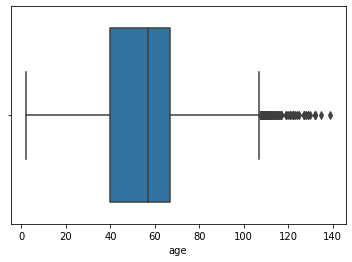

In [20]:
# Validate outlier removal and visualize the columns with boxplots
explore.df_feature_box(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a171d6f98>,
      dtype=object)

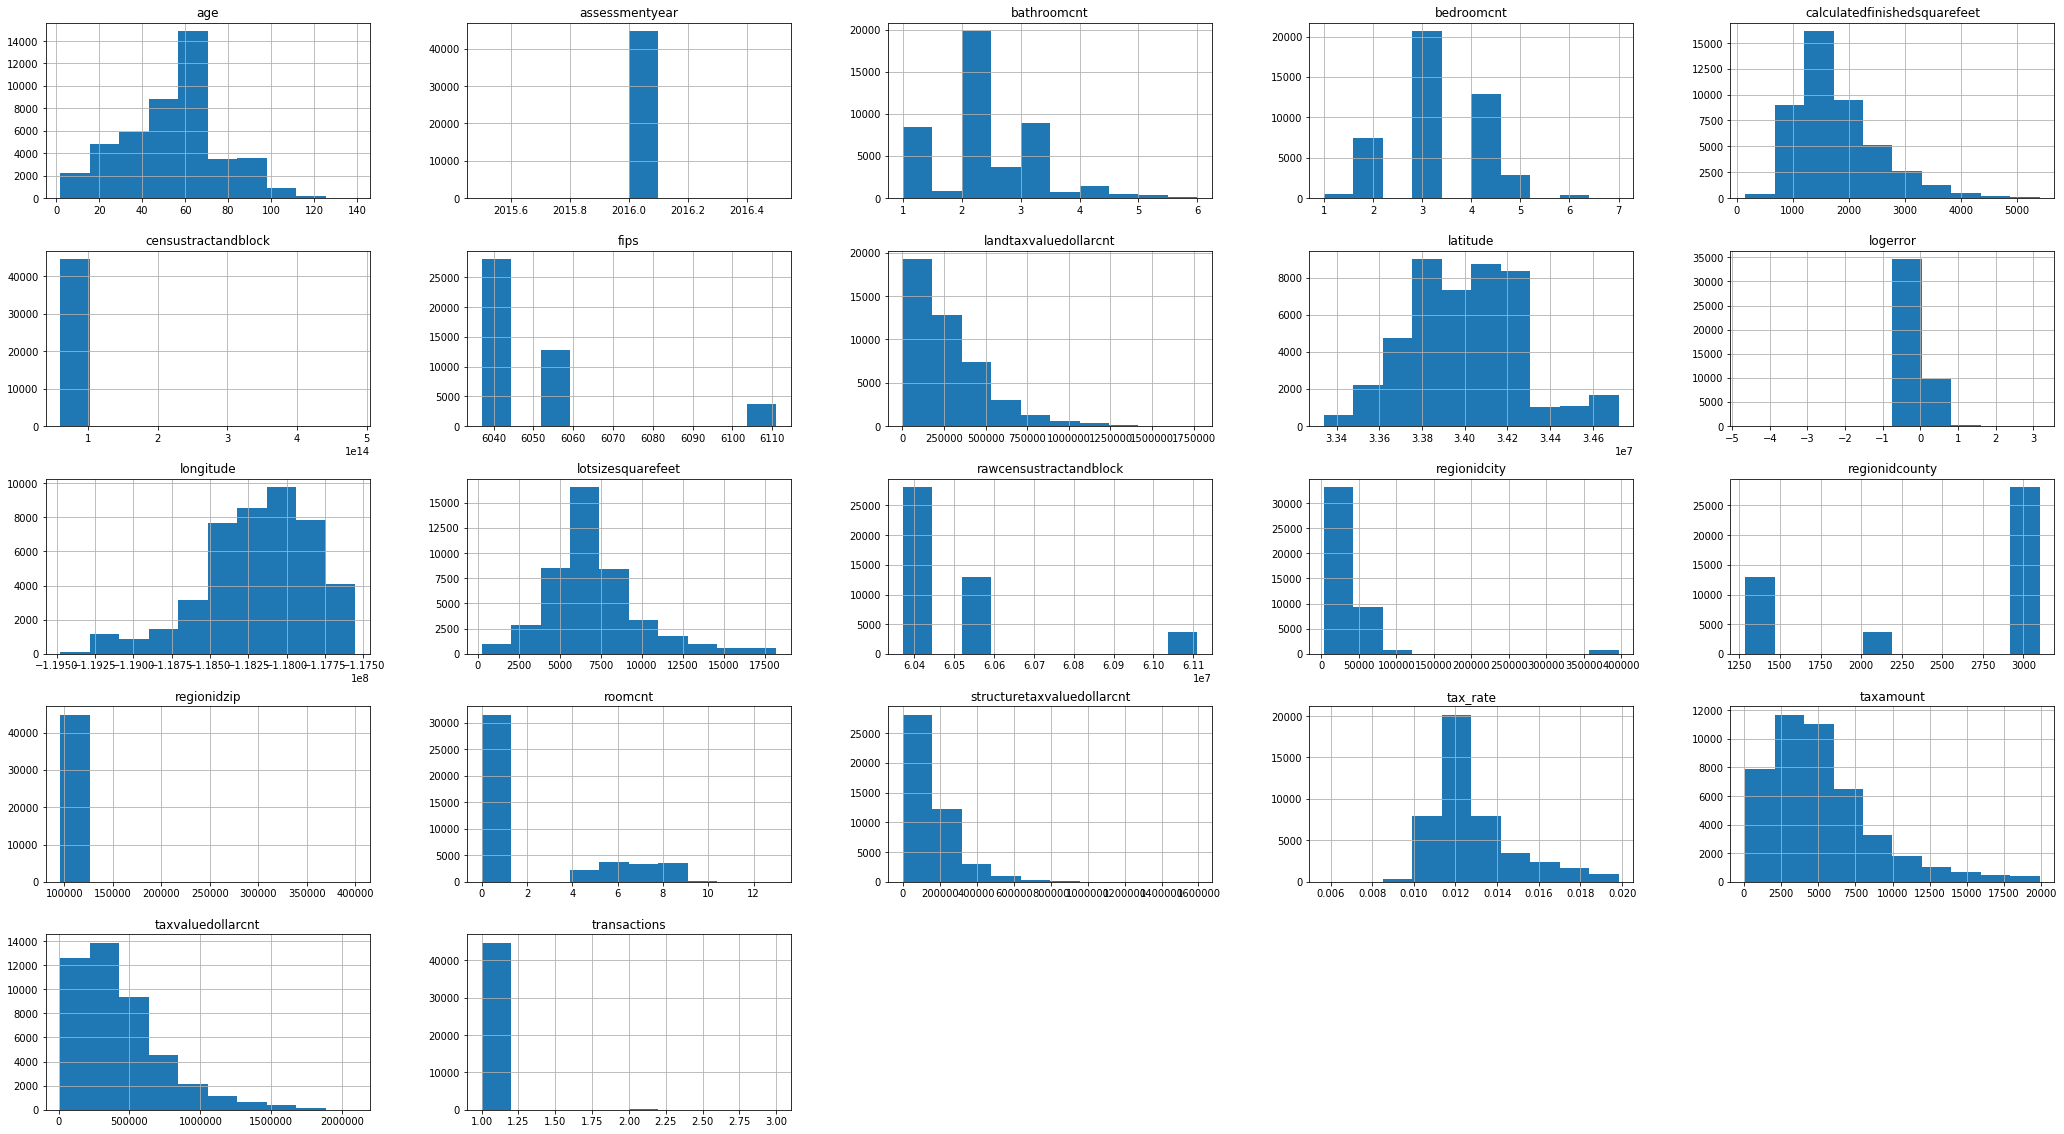

In [21]:
df.hist(figsize=(36,20))

##### After handling the outliers, we will now split our data into train and test and then impute the remaining missing values, filling them with either the mean or mode.

In [22]:
col_impute_mean = ['tax_rate', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
                   'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

col_impute_mode = ['regionidcity', 'regionidzip','censustractandblock']

In [23]:
train, test = prepare.split_my_data(df)

In [24]:
train, test = prepare.impute(train, test, "mean", col_impute_mean)
train, test = prepare.impute(train, test, "most_frequent", col_impute_mode)

In [25]:
# Lost some more rows due to dropping outliers
print(df.shape)
print(train.shape)
print(test.shape)

(44749, 25)
(35087, 25)
(8772, 25)


##### Now that all of the missing values have been handled, we will change any dtypes we feel necessary to change,

In [26]:
df["transactions"] = df.transactions.astype("float")

df["bedroomcnt"] = df.bedroomcnt.astype("int")
df["roomcnt"] = df.roomcnt.astype("int")

df["fips"] = df.fips.astype("object")
df["regionidcity"] = df.regionidcity.astype("object")
df["regionidcounty"] = df.regionidcounty.astype("object")
df["regionidzip"] = df.regionidzip.astype("object")
df["assessmentyear"] = df.assessmentyear.astype("object")

train["transactions"] = train.transactions.astype("float")

train["bedroomcnt"] = train.bedroomcnt.astype("int")
train["roomcnt"] = train.roomcnt.astype("int")

train["fips"] = train.fips.astype("object")
train["regionidcity"] = train.regionidcity.astype("object")
train["regionidcounty"] = train.regionidcounty.astype("object")
train["regionidzip"] = train.regionidzip.astype("object")
train["assessmentyear"] = train.assessmentyear.astype("object")

test["transactions"] = test.transactions.astype("float")

test["bedroomcnt"] = test.bedroomcnt.astype("int")
test["roomcnt"] = test.roomcnt.astype("int")

test["fips"] = test.fips.astype("object")
test["regionidcity"] = test.regionidcity.astype("object")
test["regionidcounty"] = test.regionidcounty.astype("object")
test["regionidzip"] = test.regionidzip.astype("object")
test["assessmentyear"] = test.assessmentyear.astype("object")

In [38]:
print(df.shape)
print(train.shape)
print(test.shape)

(44749, 25)
(35087, 25)
(8772, 25)


**The 'heatingorsystemtypeid', 'heatingorsystemdesc' and 'propertyzoningdesc' have significantly less values than the other values, but not so much so that they were removed with the function. We will just take note of this if we need to reference that later on.**

### Explore

In [28]:
def df_feature_dist(df):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.distplot(df[feature].dropna())
        plt.show()

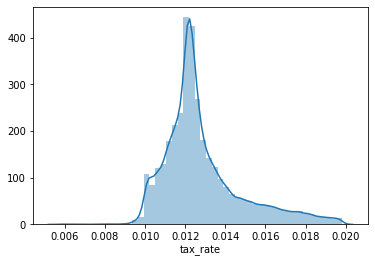

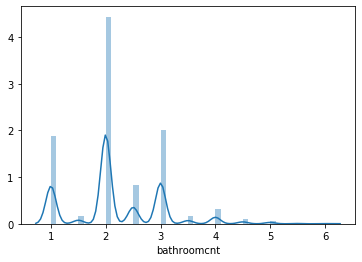

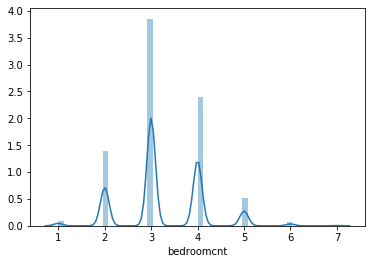

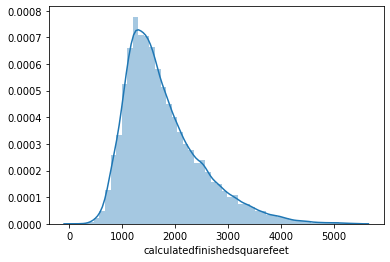

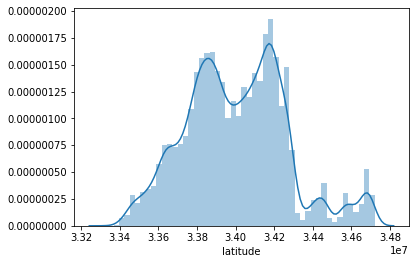

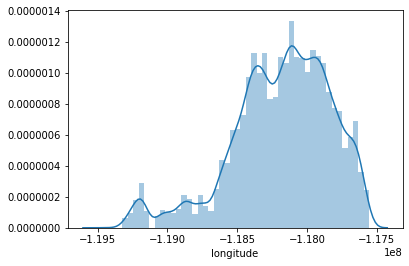

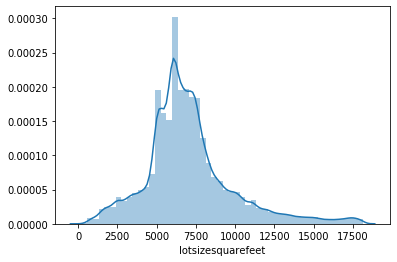

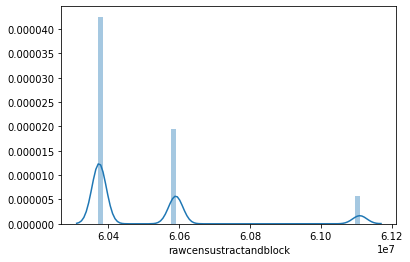

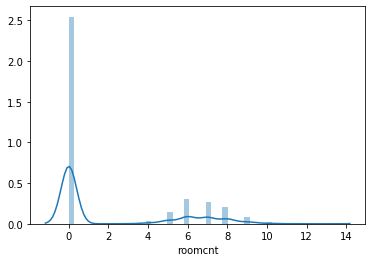

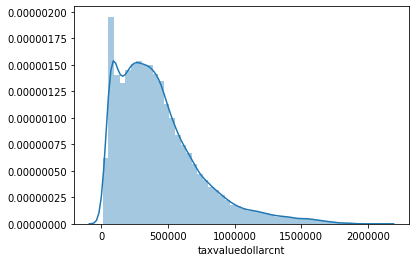

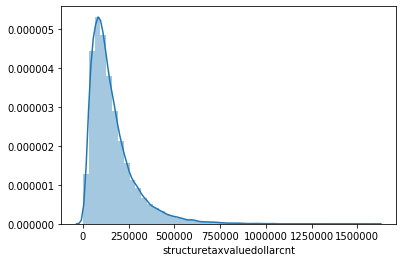

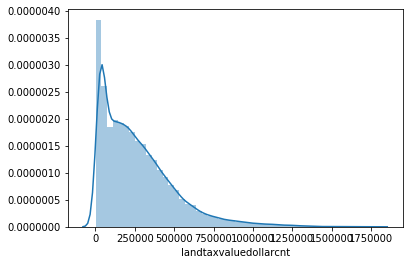

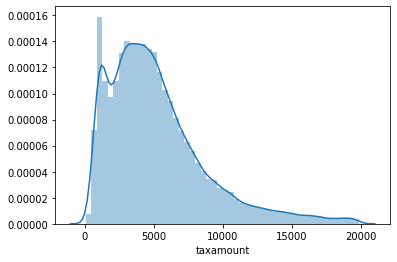

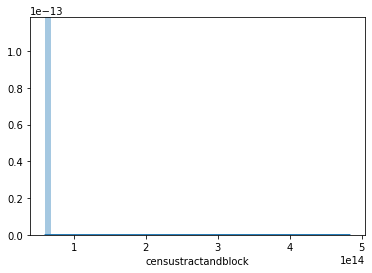

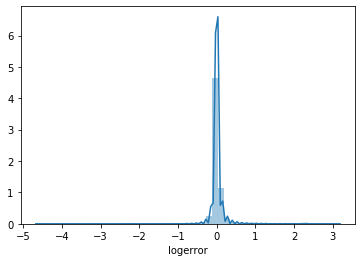

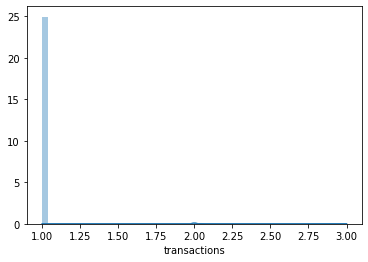

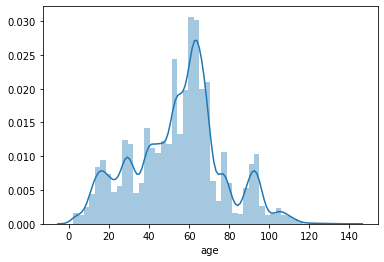

In [29]:
# Look at the distribution of features after the prep.
df_feature_dist(df)

**NOTES ABOUT FEATURES**
- calculatedfinishedsquarefeet max = 5408 seems really big
    think twice about what does calculatedfinishedsquarefeet truly means
    
    
- lotsizesquarefeet also really big, how does that compare to calc finished?

- roomcnt, bathroomcnt, bedroomcnt

- latitude and longitude need to be processed (make normal by /10^6?)

- rawcensustractandblock, censustractandblock, regionidcity, regionidcounty , regionidzip
    how to use? what value do these col bring?

- taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

- assessmentyear > double check year

- age

- transactions???

- logerror > TARGET

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.describe())

                  tax_rate          bathroomcnt           bedroomcnt  \
count            44,749.00            44,749.00            44,749.00   
mean                  0.01                 2.19                 3.25   
std                   0.00                 0.84                 0.88   
min                   0.01                 1.00                 1.00   
25%                   0.01                 2.00                 3.00   
50%                   0.01                 2.00                 3.00   
75%                   0.01                 3.00                 4.00   
max                   0.02                 6.00                 7.00   

       calculatedfinishedsquarefeet             latitude            longitude  \
count                     44,749.00            44,749.00            44,749.00   
mean                       1,781.28        34,004,913.39      -118,186,311.35   
std                          729.39           263,544.46           357,599.25   
min                        

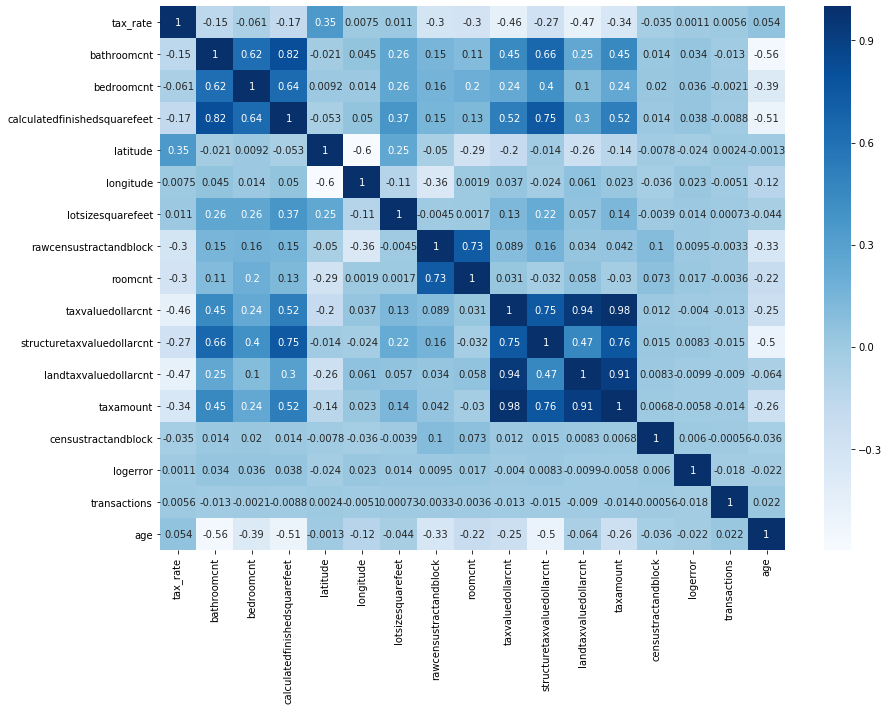

In [42]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='Blues', annot=True)

**Takeaways:** Nothing huge stands out in regards to correlation with our taget, log error.

**Task:** Look closer at individual features with more visualizations and statistical testing.

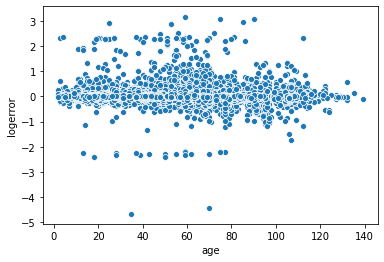

In [51]:
sns.scatterplot(x=train.age, y=train.logerror, data=train)

In [ ]:
# Look at features of a house
# Look at location of a house
# Look at value of a house

In [ ]:
x_feat = train[['bathroomcnt', 'bedroomcnt', 'calculatefinishedsquarefeet', 'lotsizesquarefeet', 'roomcnt', 'age']]

In [ ]:
k_values = []
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=5).fit(x_feat)
    inertias.append(kmeans.inertia_)
    k_values.append(k)
    
plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('Inertia')

In [ ]:
x_loc = train[['latitude', 'longitude', 'rawcensustractandblock', 'censustractandblock']]

In [ ]:
k_values = []
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=5).fit(x_loc)
    inertias.append(kmeans.inertia_)
    k_values.append(k)
    
plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('Inertia')

In [ ]:
train.columns

In [ ]:
x_val = train[['tax_rate', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'transactions']]